# TKT4108 Structural dynamics 2

## Soultion Exercise 5

**Main topics:** Signal processing and system identification

**References:** Jupyter notebook examples 

**Hint**: Take a look at the examples posted on Github

### Problem 1
In this problem, we will consider a single degree of freedom dynamic system with a mass of 100 kg, a natural frequency of 1 Hz and a damping ratio of 5%. The system is subjected to a zero mean stochastic dynamic load with a constant **one-sided** spectral density $S_x(\omega)=10^3$.

<img src="Fig_5_1.svg">

a) Obtain the auto spectral density of the response by calculating the response in the frequency domain using the power spectral density method. Calculate the standard deviation of the response.

#### Solution

The auto spectral density of the response is defined by

$$S_y(\omega) = \bar{H}(\omega) S_x(\omega) H(\omega) $$

The variance is the integral of the auto-spectral density, the standard deciation is the square root of the aut-spectral density

$$ \sigma_y = \sqrt{ \int_{-\infty}^{\infty}{S_y(\omega)} d\omega } $$

(0.0, 20.0)

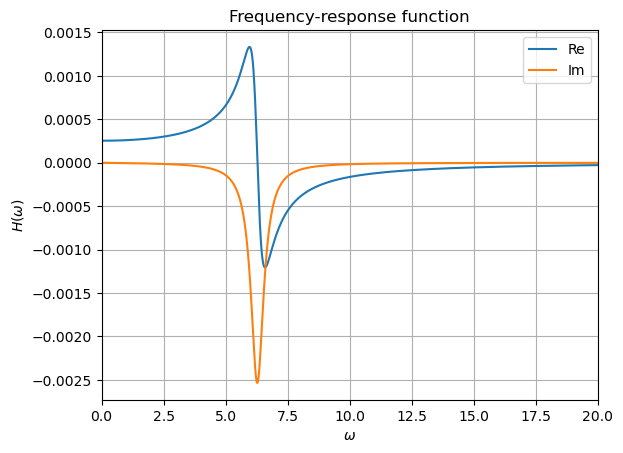

In [56]:
import numpy as np
from matplotlib import pyplot as plt
from time_integration import *
from scipy import signal as spsi

fn = 1
zeta = 5/100
omegan = 2*np.pi*fn
ms = 100
ks = omegan**2*ms

cs = 2*zeta*ms*omegan

w = np.linspace(0,100,100001)

H = 1/(-w**2*ms + 1j*w*cs + ks)

plt.figure()
plt.plot(w,np.real(H),label="Re")
plt.plot(w,np.imag(H),label="Im")
plt.xlabel("$\omega$")
plt.ylabel("$H(\omega)$")
plt.title("Frequency-response function")
plt.grid()
plt.legend()
plt.xlim(0,20)

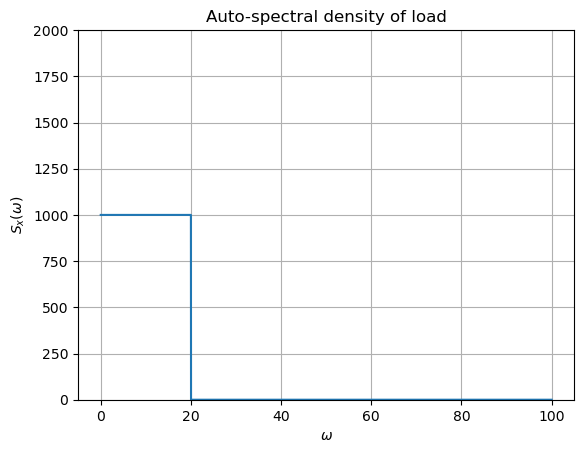

In [57]:
Sx = np.ones(len(w))*10**3
Sx[w>20] =  0

plt.figure()
plt.plot(w,Sx)
plt.xlabel("$\omega$")
plt.ylabel("$S_x(\omega)$")
plt.grid()
plt.title("Auto-spectral density of load")
plt.ylim(0,2000);


The standard deviation is 0.0796


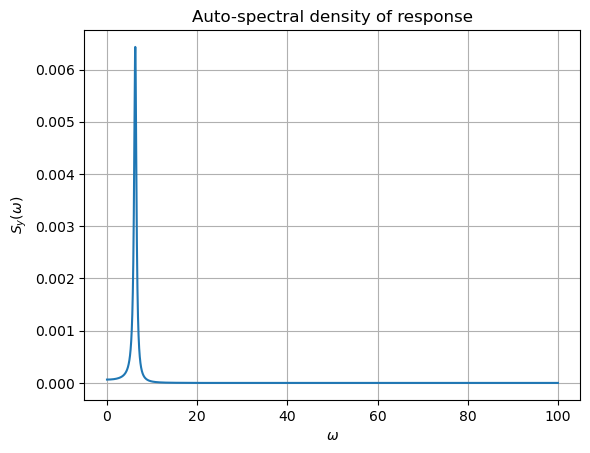

In [58]:
Sy = np.abs(H)**2*Sx

plt.figure()
plt.plot(w,Sy)
plt.xlabel("$\omega$")
plt.ylabel("$S_y(\omega)$")
plt.grid()
plt.title("Auto-spectral density of response");

print("The standard deviation is " + str(np.ceil(np.trapz(Sy,w)**0.5*1e4)/1e4))

b) Make a python code that generates realizations of the load by Monte Carlo simulations. Calculate the dynamic response of the system using Newmark's method. How long time series should we consider to obtain reasonable estimates of the standard deviation of the response?

#### Solution
We can obtain realizations of the load based on its auto-spectral density by Monte Carlo simulation. We use the formulation based on the fast Fourier transform since this is the most effective approach.

$$x(t) = \Re \left(IFFT \left( A_k e^{i \phi_k} \right) \right)$$

$$A_k = \sqrt{2 S_x(\omega_k) \Delta \omega} $$

Here $S_x(\omega_k)$ is the auto-spectral density of the process, and $\phi_k$ is random phase angles evenly distributed between $0$ and $2\pi$

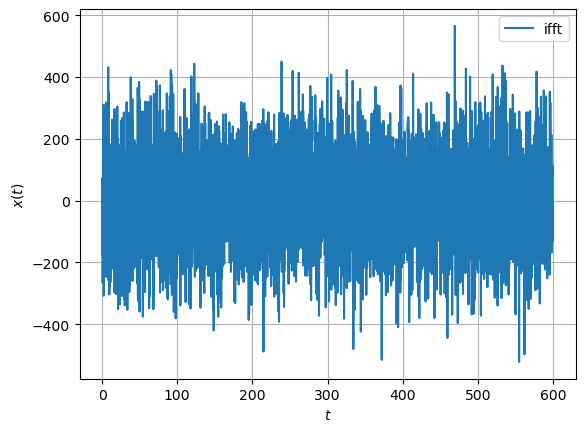

In [59]:
dw = w[1]-w[0] # Frequency spacing
phi = np.random.rand(w.shape[0])*2*np.pi # Random phase angles 
c = (2*Sx*dw)**0.5*np.exp(1j*phi) # The complex amplitude inclusing the phase angle
xifft = np.real(np.fft.ifft(c)*w.shape[0]) # The ifft
tifft = np.linspace(0,2*np.pi/dw,w.shape[0]) # time axis

t = np.arange(0,600,0.02)
x = np.interp(t,tifft,xifft)

plt.figure()
plt.plot(t,x,label = 'ifft')
#plt.plot(t,x,label= 'cos');
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.grid()
plt.legend();




Response by Newmark's method

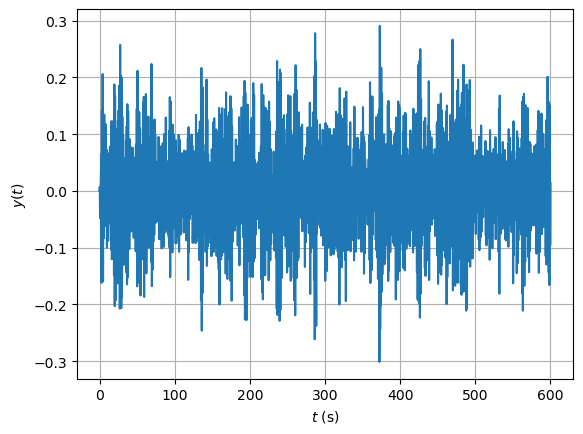

In [60]:
h = t[1]-t[0]

u0 = np.zeros((1,1))
udot0 = np.zeros((1,1))

gamma = 1/2
beta = 1/4

y, _,_ = linear_newmark_krenk(np.array([[ms]]),np.array([[cs]]),np.array([[ks]]),np.array([x]),u0,udot0,h,gamma,beta)

plt.figure()
plt.plot(t,y[0,:])
plt.xlabel("$t$ (s)")
plt.ylabel("$y(t)$")
plt.grid()

To asses how long time series is need to estimate the standard deviation, we can calculate the standard deviation as function of the length of the time series.

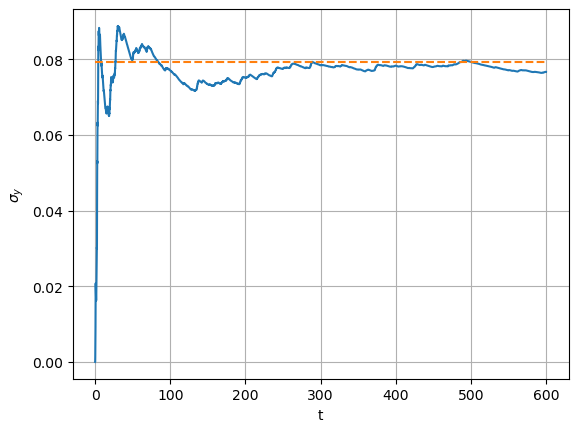

In [61]:
std_time = np.zeros(t.shape[0])
for k in range(1,t.shape[0]):
    std_time[k] = np.std(y[0,0:k])
    
plt.figure()
plt.plot(t,std_time)
plt.hlines(0.0792,0,600,color="C1",linestyle="--")
plt.grid()
plt.ylabel("$\sigma_y$")
plt.xlabel("t");

The plot above illustrates that we get a pretty good estimate of the standard deviation considering a time series of 400 seconds duration. This depends on the particular realization of the loading and it is important to perform a check whether the estimated statistical properties have converged. In general, the duration will also depend on the natural frequencies in the response. In this example the frequency was 1 Hz, so approximately 400 cycles were needed.

c) Make a python code that estimates the auto-spectral density of the response from the simulated times series and present results by considering the average auto-spectral density of 10 time series that each are 600 seconds long. 

d) Compare the auto-spectral density estimated from the time domain data to the frequency domain solution. Comment on any discrepancies you observe.


#### Solution

The auto-spectral density can be estimated as follows:

 $$ S_{x}(f_k)  = \lim_{T\rightarrow \infty} \text{E} [ \: T \cdot X_k \bar{X}_k \: ]  $$



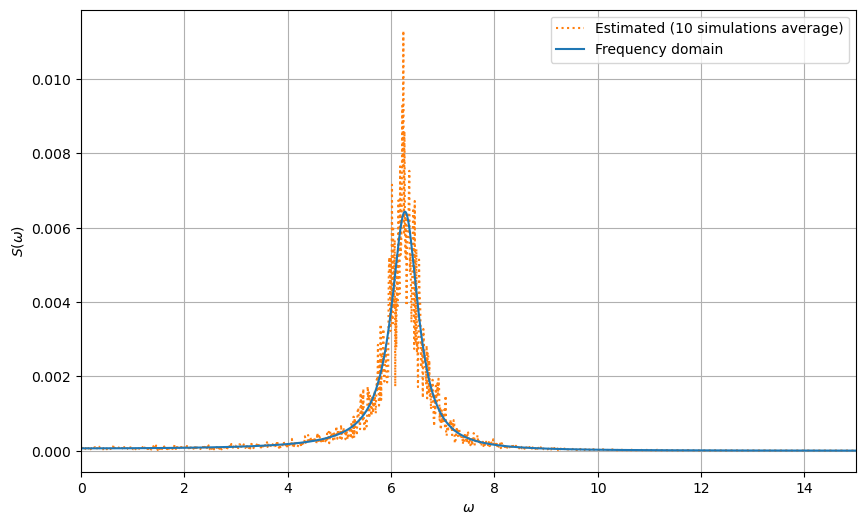

In [62]:
Nsim = 10
Sy_est_twosided_mean = np.zeros(len(t))

for k in range(Nsim):
    phi = np.random.rand(w.shape[0])*2*np.pi 
    c = (2*Sx*dw)**0.5*np.exp(1j*phi)
    xifft = np.real(np.fft.ifft(c)*w.shape[0]) 
    tifft = np.linspace(0,2*np.pi/dw,w.shape[0]) 

    t = np.arange(0,600,0.02)
    x = np.interp(t,tifft,xifft)
    
    h = t[1] - t[0]
    
    y, _,_ = linear_newmark_krenk(np.array([[ms]]),np.array([[cs]]),np.array([[ks]]),np.array([x]),u0,udot0,h,gamma,beta)

    T=t[-1] # Total measurement period

    Yfft = np.fft.fft(y)/len(t)
    Yfft = np.fft.fftshift(Yfft) # This shifts the DFT negative f, mean, positive f: [-w 0 w]

    f = np.linspace(-1/2/h,1/2/h,t.shape[0]); # Frequency axis in Hz

    Sy_est_twosided=T*np.real(np.multiply(Yfft,np.conj(Yfft))) # Estimate spectrum (two-sided and function of Hz)
    
    Sy_est_twosided_mean = Sy_est_twosided_mean + Sy_est_twosided

Sy_est_twosided_mean = Sy_est_twosided_mean/Nsim
w_est=f[f>0]*2*np.pi
Sy_est_mean=Sy_est_twosided_mean[0,f>0]/(2*np.pi)*2
    
# Plot and compare with exact solution
plt.figure(figsize=(10,6))   

plt.plot(w_est,Sy_est_mean,':' ,label = 'Estimated' + ' (' + str(Nsim) +' simulations average)' ,color="C1") 
plt.plot(w,Sy,'-' ,label = 'Frequency domain',color="C0") 
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.xlim(0,15)
plt.grid()
plt.legend();

We see that the two graphs are similar (as they should be). The estimate is still "noisy", and will fully converge as the time series becomes longer ($T\rightarrow \infty$) and/or the number of averages are increased ($N\rightarrow \infty$).

### Problem 2

In this problem, we will consider the 5-story shear frame displayed below. The mass of each story is 1000 kg, and the columns are made of RHS 100x100x6.3 Set $I_y = 3.36 \cdot 10^{-6} $ m$^4$ and $E=210\cdot 10^3$ MPa. The damping ratio of all modes is 5 \%. The story height is 3 meters.

<img src="Fig_5_2.svg">

a) Obtain the mass, stiffness, and damping matrices of the structure.

Hint: the modal damping is $\tilde{\mathbf{C}}=\mathbf{\Phi}^\text{T}\mathbf{C}\mathbf{\Phi}$. Define the modal damping and use it to calculate the damping in original coordinates.

#### Solution


In [63]:
import numpy as np
from scipy import linalg as spla

MM = np.eye(5) *1000
KK = np.zeros((6,6))
EI = 2.1e11*3.34e-6
L = 3
ks = 2 *12*EI/L**3

for k in range(5):
    KK[k+1,k+1] = KK[k+1,k+1] + ks
    KK[k,k] = KK[k,k] + ks
    KK[k+1,k] = KK[k+1,k] -ks
    KK[k,k+1] = KK[k,k+1] -ks

KK = KK[1::,1::] # Introduce boundary conditions

lam, vec = spla.eig(KK,MM)

indx = np.argsort(lam)
lam = lam[indx]


vec = vec[:,indx]

f = np.real(lam**0.5)/2/np.pi

MM_modal = vec.T @ MM @ vec

CC_modal = 2*np.eye(5)*5/100*MM_modal*np.diag(f)*2*np.pi

CC = vec @ CC_modal @ vec.T

# Verify that the target damping have been achived
A = np.zeros((2*MM.shape[0],2*MM.shape[0]))
A[MM.shape[0]::,0:MM.shape[0]] = -np.linalg.inv(MM) @ KK
A[MM.shape[0]::,MM.shape[0]::] = -np.linalg.inv(MM) @ CC
A[0:MM.shape[0],MM.shape[0]::] = np.eye(MM.shape[0])

s,vec = np.linalg.eig(A)
f = np.abs(s)/2/np.pi
zeta = -np.real(s)/np.abs(s)

print(zeta)    
    

[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]


b) The frame is subjected to two uncorrelated loads with constant auto-spectral one-sided density:

$$ S_{X}(\omega)= \left\{ \begin{array} {c} 10^8 \quad \omega \le 60 \\ 0 \quad \omega > 60 \end{array} \right. $$

Calculate the auto-and cross-spectral densities of the response of stories 1 and 3. Use the power spectral density method.


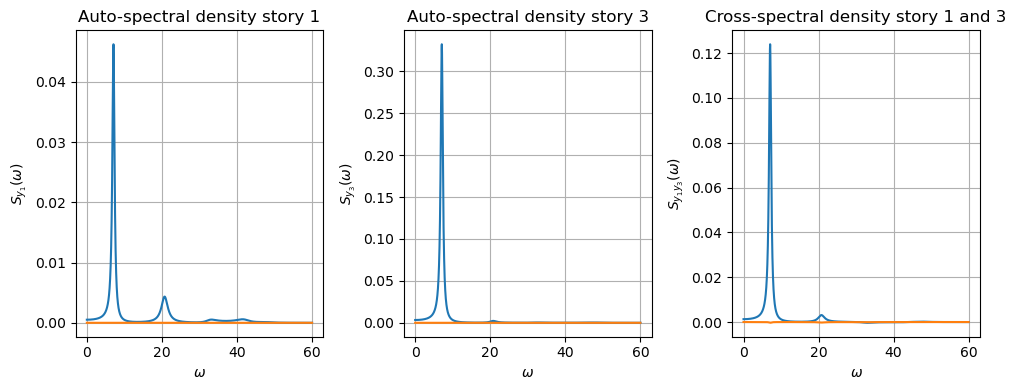

In [64]:
w = np.linspace(0,60,10000)
HH = np.zeros((MM.shape[0],MM.shape[0],len(w)),dtype = complex)
SQSQ = np.zeros((MM.shape[0],MM.shape[0],len(w)))
SySy = np.zeros((MM.shape[0],MM.shape[0],len(w)),dtype = complex)

SQSQ[1,1,w<60] = 10**8

SQSQ[3,3,w<60] = 10**8

for k in range(w.shape[0]):
    HH[:,:,k] = np.linalg.inv(-w[k]**2*MM + 1j*w[k]*CC + KK)
    SySy[:,:,k] = np.conj(HH[:,:,k]) @ SQSQ[:,:,k] @ HH[:,:,k].T
    
fig, axs = plt.subplots(1,3,figsize=(10,4))

axs[0].plot(w,np.real(SySy[0,0,:]))
axs[0].plot(w,np.imag(SySy[0,0,:]))
axs[0].set_xlabel("$\omega$")
axs[0].set_ylabel("$S_{y_1}(\omega$)")
axs[0].set_title("Auto-spectral density story 1")
axs[0].grid(True)

axs[1].plot(w,np.real(SySy[2,2,:]))
axs[1].plot(w,np.imag(SySy[2,2,:]))
axs[1].set_xlabel("$\omega$")
axs[1].set_ylabel("$S_{y_3}(\omega$)")
axs[1].set_title("Auto-spectral density story 3")
axs[1].grid(True)

axs[2].plot(w,np.real(SySy[0,2,:]))
axs[2].plot(w,np.imag(SySy[0,2,:]))
axs[2].set_ylabel("$S_{y_1 y_3}(\omega$)")
axs[2].set_xlabel("$\omega$")
axs[2].set_title("Cross-spectral density story 1 and 3")
axs[2].grid(True)

plt.tight_layout()



c) Create a realization of the load, and solve the dynamic response of the frame in the time domain. Obtain response for 1 hour.


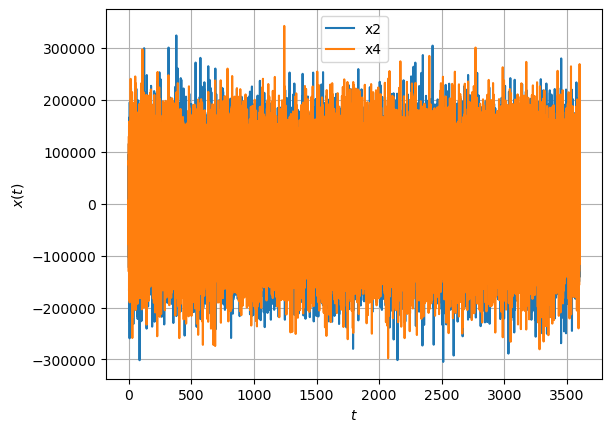

In [65]:
wfft = np.arange(0,70,0.001)
Sx = np.ones(len(wfft))*10**8
Sx[wfft>60] =  0
dwfft = wfft[1]-wfft[0] # Frequency spacing

tifft = np.linspace(0,2*np.pi/dwfft,wfft.shape[0]) # time axis
t = np.arange(0,60*60,0.01)

phi = np.random.rand(wfft.shape[0])*2*np.pi # Random phase angles 
c = (2*Sx*dwfft)**0.5*np.exp(1j*phi) # The complex amplitude inclusing the phase angle
xifft = np.real(np.fft.ifft(c)*wfft.shape[0]) # The ifft
x2 = np.interp(t,tifft,xifft)

phi = np.random.rand(wfft.shape[0])*2*np.pi # Random phase angles 
c = (2*Sx*dwfft)**0.5*np.exp(1j*phi) # The complex amplitude inclusing the phase angle
xifft = np.real(np.fft.ifft(c)*wfft.shape[0]) # The ifft
x4 = np.interp(t,tifft,xifft)


plt.figure()
plt.plot(t,x2,label = 'x2')
plt.plot(t,x4,label = 'x4')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.grid()
plt.legend();

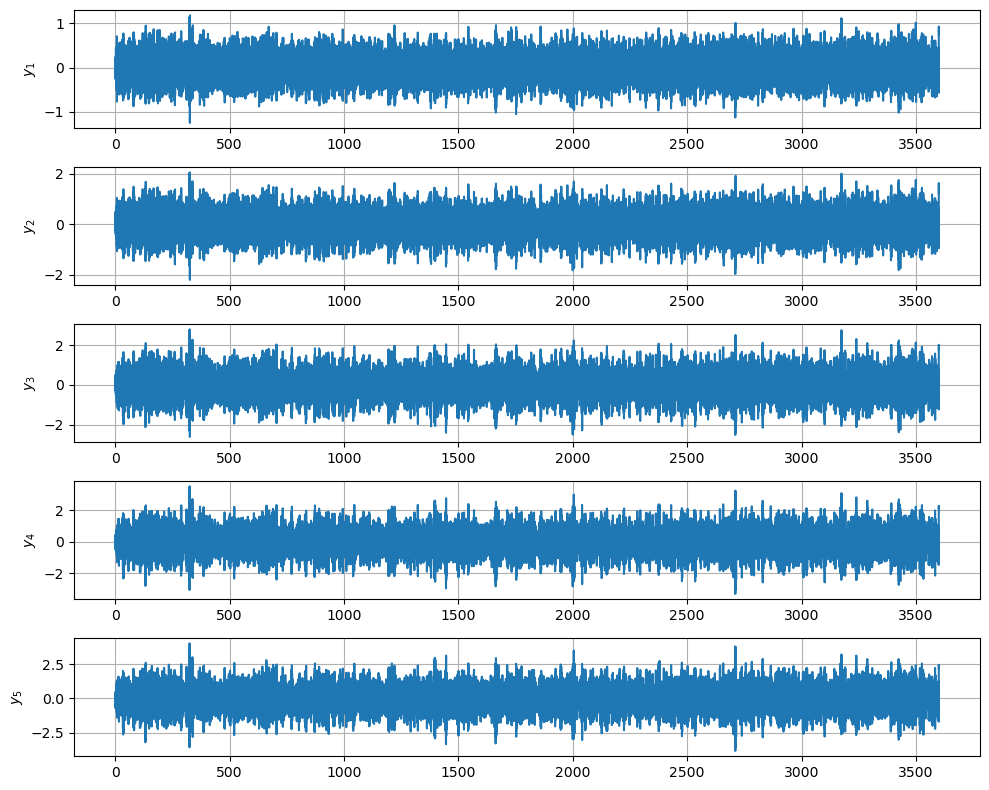

In [66]:
x = np.zeros((5,len(t))) # Define the load history
x[1,:] = x2
x[3,:] = x4

u0 = np.zeros((5,1))

dt = t[2] - t[1]

y, _,_ = linear_newmark_krenk(MM,CC,KK,x,u0,udot0,dt,gamma,beta)

fig, axs = plt.subplots(5,1,figsize=(10,8))

for k in range(5):
    axs[k].plot(t,y[k,:])
    axs[k].grid(True)
    axs[k].set_ylabel("$y_" + str(k+1) + "$")
    
plt.tight_layout()

d) Estimate the auto spectral densities of the response in degrees of freedom 1 and 3 using Welch's method. How many divisions would you recommend using?


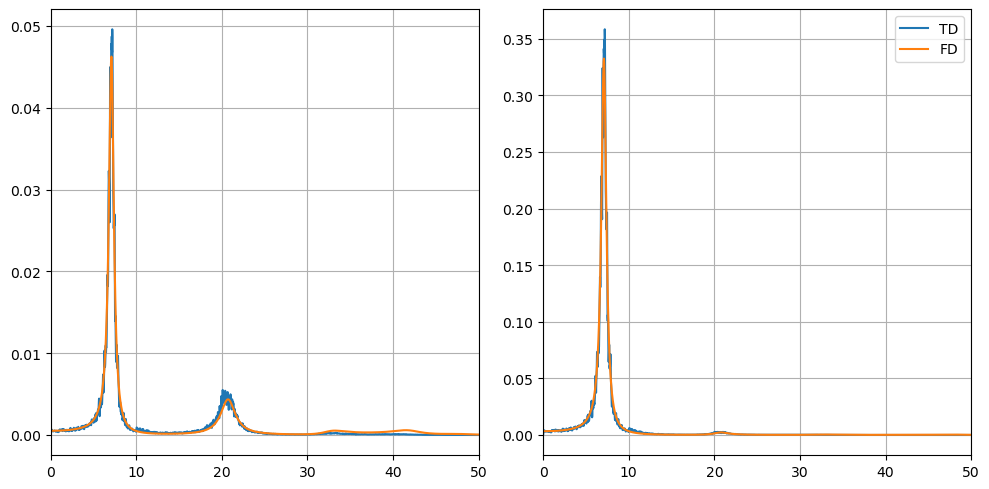

In [67]:
ndivisions = 20 # Number of divisions of the time series (total segments)
nwindow = np.ceil(len(t)/ndivisions) # Length of window/segment
noverlap = np.ceil(nwindow/2)

nfft_pow2 = 2**(np.ceil(np.log2(nwindow))) # Next power of 2 for zero padding

# Call welch from scipy signal processing
f, Sy_1_tmp = spsi.welch(y[0,:], fs=1/dt, window='hann', nperseg=nwindow, noverlap=noverlap, nfft=nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

w_welch = f*2*np.pi # Transform to rad/s
Sy_1 = Sy_1_tmp/(2*np.pi) # Transform to rad/s

# Call welch from scipy signal processing
f, Sy_3_tmp = spsi.welch(y[2,:], fs=1/dt, window='hann', nperseg=nwindow, noverlap=noverlap, nfft=nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

Sy_3 = Sy_3_tmp/(2*np.pi) # Transform to rad/s


fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].plot(w_welch,Sy_1,label = "TD")
axs[0].plot(w,np.real(SySy[0,0]),label="FD")
axs[0].set_xlim(0,50)
axs[0].grid(True)


axs[1].plot(w_welch,Sy_3,label = "TD")
axs[1].plot(w,np.real(SySy[2,2]),label="FD")
axs[1].set_xlim(0,50)
axs[1].grid(True)

axs[1].legend()

plt.tight_layout()



Anything between 5 and 25 divisions seems to give decent estimates. The higher side (approx. 20) gives good results since the time series is very long (1 hour), so the length of each division still is relatively long. A much short time series could not have been divided into so many divisions with good results.

In [68]:
e) Estimate the cross-spectral density of the response in degrees of freedom 1 and 3. How many windows would you recommend using?

Object `using` not found.


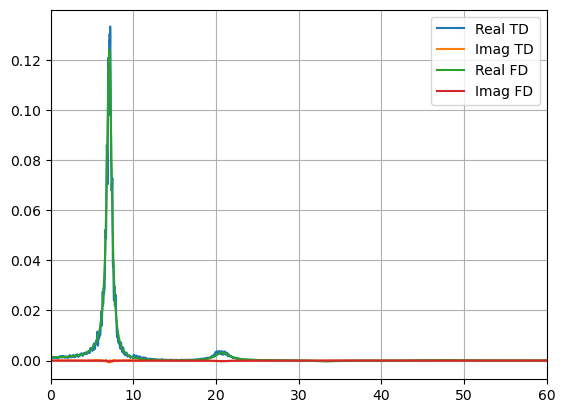

In [69]:
# Call welch from scipy signal processing
f, Sy_13_tmp = spsi.csd(y[0,:], y[2,:], fs=1/dt, window='hann', nperseg=nwindow, noverlap=noverlap, nfft=nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

Sy_13 = Sy_13_tmp/(2*np.pi) # Transform to rad/s

plt.figure()
plt.plot(w_welch,np.real(Sy_13),label="Real TD")
plt.plot(w_welch,np.imag(Sy_13),label="Imag TD")

plt.plot(w,np.real(SySy[0,2]),label="Real FD")
plt.plot(w,np.imag(SySy[0,2]),label="Imag FD")

plt.xlim(0,60)

plt.legend()
plt.grid()




The conclusions here are largely the same as the previous question.